Extracting MODIS data (Terra, Aqua, L1 + L2) by downloading from EarthData for 2015/16 in the Amazon

In [20]:
import xarray as xr
import earthaccess
import datetime as dt
from pprint import pprint
import numpy as np
import pandas as pd
import time
import os
import fsspec
import geopandas as gpd
from pyhdf.SD import SD
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

In [21]:
#source: https://forobs.jrc.ec.europa.eu/amazon
amazonia = gpd.read_file('/projects/shared-buckets/coffield/amazonia/amazonia_polygons.shp')
amazonia = amazonia.dissolve()
amazonia.explore()

/tmp/ipykernel_327/2039224114.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = amazonia.explode().reset_index(drop=True)
/tmp/ipykernel_327/2039224114.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exploded.AREA = exploded.geometry.area


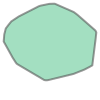

In [22]:
exploded = amazonia.explode().reset_index(drop=True)
exploded.AREA = exploded.geometry.area
#exploded.loc[0:1,:].explore()

geom = exploded.loc[0, 'geometry']
#geom = geom.simplify(0.4) #about 40km
geomc = geom.convex_hull
geomc

In [6]:
geom_string = str(geomc)[10:-2]
geom_string

'-63.43034744262695 -20.50092315673828, -63.767757415771484 -20.4754581451416, -63.88496017456055 -20.453052520751953, -64.2006607055664 -20.392698287963867, -74.12335968017578 -14.532249450683594, -74.5932388305664 -14.228923797607422, -74.72480773925781 -14.112621307373047, -75.06462860107422 -13.637988090515137, -76.19805145263672 -11.878687858581543, -79.47205352783203 -5.971370220184326, -79.59452819824219 -5.739683151245117, -79.59874725341797 -5.696430683135986, -79.56692504882812 -5.240001201629639, -79.37553405761719 -3.0267882347106934, -78.80882263183594 -0.7988593578338623, -78.71505737304688 -0.6551738381385803, -77.66124725341797 0.7232109904289246, -76.69065856933594 1.909584879875183, -76.65711975097656 1.9333646297454834, -73.87409973144531 3.7827863693237305, -66.3194580078125 7.6399993896484375, -65.66111755371094 7.877499580383301, -62.25083923339844 8.584165573120117, -62.232505798339844 8.586111068725586, -60.34788131713867 8.647115707397461, -60.34256362915039 8.

In [7]:
#for list of tuples for earthaccess
strings = [s.split(' ') for s in geom_string.split(',')]
strings2 = []
for i in strings:
    strings2.append([x for x in i if x])

for i in range(len(strings2)):
    strings2[i] = [np.round(float(j),4) for j in strings2[i]]
tuples = strings2[::-1]
tuples[:10]

[[-63.4303, -20.5009],
 [-62.9783, -20.4755],
 [-62.8128, -20.4564],
 [-53.0075, -18.0665],
 [-48.9169, -16.4386],
 [-47.0239, -15.4608],
 [-45.9523, -14.8683],
 [-45.8789, -14.8091],
 [-45.8755, -14.7857],
 [-44.6164, -4.7414]]

In [23]:
extent = geom.bounds

start = dt.date(2015,9,1)

months = [start + pd.DateOffset(months=i) for i in range(9)]
months

[Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00')]

In [9]:
def download_data(sat, products):
    
    files = {}

    earthaccess.login(strategy='netrc') #every hour or every DAAC
    
    print('downloading', start, end)

    #Level1 data from LAADS ------
    #geolocation 03
    results = earthaccess.search_data(
        short_name=products[0],
        polygon=tuples,
        temporal=(start, end),
        count=800)
    files[products[0]] = earthaccess.download(results, f'/projects/my-public-bucket/modis/{products[0]}/')
    #would be better to download to tmp for DPS jobs
    
    earthaccess.login(strategy='netrc') #every hour or every DAAC
    
    #Level2 data 14IMG
    results = earthaccess.search_data(
        short_name=products[1],
        polygon=tuples,
        temporal=(start, end),
        count=800)     
    files[products[1]] = earthaccess.download(results, f'/projects/my-public-bucket/modis/{products[1]}/')
    
    return files

In [10]:
def extract_fires(sat, products, files):
    
    all_dets = pd.DataFrame() #list of all known+candidate detections per satellite

    for i in range(len( files[products[0]] )): #VNP03IMG or VJ103IMG
               
        timestamp = files[products[0]][i].split('.')[-5:-3]
        print(timestamp)
        year = timestamp[0][1:5]
        day = timestamp[0][5:8]
        timee = timestamp[1]
        date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %-d') 
        acq_datetime = dt.datetime.strptime(year+day+timee[:2]+timee[2:], '%Y%j%H%M').strftime('%Y-%m-%d %H:%M:00 +00:00') 
        #daytime = int(time) > 1500 #depends on timezone

        try:
            #open 03 geolocation
            geo_file = files[products[0]][i].split('/')[-1]
            geo = xr.open_dataset(f'/projects/shared-buckets/coffield/modis/{products[0]}/{geo_file}', engine='netcdf4')
            lon = geo['Longitude'][:]
            lat = geo['Latitude'][:]
            _, j = np.indices(geo.Longitude.shape) #line and sample

            scene = (lon > extent[0]) & (lon < extent[2]) & (lat > extent[1]) & (lat < extent[3])

            #crop down the datasets for memory 
            indices = np.where(scene)
            if len(indices[0])==0 or len(indices[1])==0:
                print('no data in scene')
                continue
            x0 = indices[0].min()
            x1 = indices[0].max()
            y0 = indices[1].min()
            y1 = indices[1].max()

            lon = lon[x0:x1, y0:y1]
            lat = lat[x0:x1, y0:y1]
            j = j[x0:x1, y0:y1]

            if lon.size==0: continue #skip ahead

            #open 14 fire product
            match = [f for f in files[products[1]] if '.'.join([timestamp[0],timestamp[1]]) in str(f)][0]
            fire_file = match.split('/')[-1]
            data = SD(f'/projects/shared-buckets/coffield/modis/{products[1]}/{fire_file}')

            if data.attributes()['DayPix'] > data.attributes()['NightPix']:#1000000:
                daynight='Day'
            else: daynight='Night'

            qa = data.select('algorithm QA').get()
            qa = qa[x0:x1, y0:y1]

            fire = data.select('fire mask').get()
            fire = fire[x0:x1, y0:y1]
            fires = fire > 6

            ''' #old method with xarray
            data = xr.open_dataset(f'/projects/shared-buckets/coffield/modis/{products[1]}/{fire_file}', engine='netcdf4')

            if data.DayPix > (data['fire mask'].size / 2): #more than half day pixels
                daynight = 'Day'
            else: daynight='Night'

            fire = data['fire mask'][:]
            fire = fire[x0:x1, y0:y1]
            fires = fire > 6

            qa = data['algorithm QA'][:]
            '''

        except RuntimeError as error:
            print('error with file', timestamp, error)
            continue
        except:
            print('error with file', timestamp)
            stop
            continue


        #candidate extraction -------------------------------------------

        values, counts = np.unique(qa, return_counts=True)

        table = pd.DataFrame(index = values, columns=range(29,-1,-1)) #[22,21,...1]
        for i1 in table.index:
            b = np.binary_repr(i1, width=30)
            b = [int(s) for s in b]
            table.loc[i1, :] = b

        #report back all the pixels that have a 5 ~ potential fire pixels
        keep = table[table.loc[:,5]==1].index
        keep = np.isin(qa[:], keep) | (fires) #"fires" because some low conf are Test 16 pixel saturation

        if keep.sum()==0:
            print('no dets')
            continue #skip ahead if no detections

        #build pandas table for exporting, following VIIRS L2 columns
        i_dets = pd.DataFrame()
        i_dets['longitude'] = list(lon.values[keep])
        i_dets['latitude'] = list(lat.values[keep])
        i_dets['fire_mask'] = list(fire[keep])
        i_dets['daynight'] = daynight[0]
        i_dets['confidence'] = i_dets.fire_mask
        i_dets.confidence = i_dets.confidence.replace({0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
        i_dets['acq_date'] = dt.datetime.strptime(year+day, '%Y%j').strftime('%Y/%m/%d') 
        i_dets['acq_time'] = timee
        i_dets['acq_datetime'] = acq_datetime
        i_dets['j'] = list(j[keep]) #sample number for pixel size / VZA lookup

        i_dets = i_dets[i_dets.fire_mask>4] #remove non-land candidates
        
        #crop down to defined extent
        i_dets = i_dets[(i_dets.longitude > extent[0]) & (i_dets.longitude < extent[2]) & (i_dets.latitude > extent[1]) & (i_dets.latitude < extent[3])]

        all_dets = pd.concat([all_dets, i_dets])

        del geo, scene, data, lon, lat, i_dets
        
    #save csv of detections
    return all_dets 

In [11]:
months

[Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00')]

In [15]:
%%time 

for m in range(8, len(months)-1):
    start = months[m].strftime('%Y-%m-%d') 
    end = months[m+1].strftime('%Y-%m-%d') 
    print(start, '--------------------------------')

    for sat in ['Aqua','Terra']:
        
        print(sat, '------')
        if sat=='Terra': products = ['MOD03','MOD14']
        elif sat=='Aqua': products = ['MYD03','MYD14']

        #FETCH CLOUD SWATHS -----------------
        files = download_data(sat, products) 

        #pprint(files)
        
        #EXTRACT FIRE PIXELS --------------------------------
        all_dets = extract_fires(sat, products, files)
        
        #export csv
        all_dets.to_csv(f'/projects/my-public-bucket/modis/outputs/amazon/{months[m].strftime("%Y_%m")}_detections_{sat}.csv', index=False)

print('done')

done
CPU times: user 318 µs, sys: 53 µs, total: 371 µs
Wall time: 325 µs


<h4>Remove files after detections extracted

In [24]:
for p in ['MOD03','MOD14','MYD03','MYD14']:
    rm = os.listdir(f'/projects/my-public-bucket/modis/{p}/')
    rm = [f for f in rm if f[-3:]=='hdf']
    #rm[:10], len(rm)
    
    for f in rm:
        os.remove(f'/projects/my-public-bucket/modis/{p}/{f}') 

<h4>Clip to Amazon and mask forest

In [25]:
import rioxarray
forest = rioxarray.open_rasterio(f'/projects/shared-buckets/coffield/mapbiomas2015_mask.tif')[0,:,:]
forest

<xarray.DataArray (y: 7144, x: 8437)> Size: 60MB
[60273928 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 67kB -80.5 -80.5 -80.5 ... -42.62 -42.62 -42.61
  * y            (y) float64 57kB 10.92 10.91 10.91 ... -21.16 -21.16 -21.17
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      remapped

^This comes from Mapbiomas Amazonia LULC via Google Earth Engine, reprojected to 500m. Forest cover classes "Forest","Natural Forest", "Forest Formation" are combined as a forest mask (excluding savanna, mangroves, and flooded forest). Mask is reprojected to 500m using the mode, such that pixels with >50% forest have value 1 and others 0. Alternatively the 'mapbiomas2015.tif' file is the full set of classes at 500m (not binary). See mapbiomas GEE script for details:
https://code.earthengine.google.com/?accept_repo=users/coffield/fires 

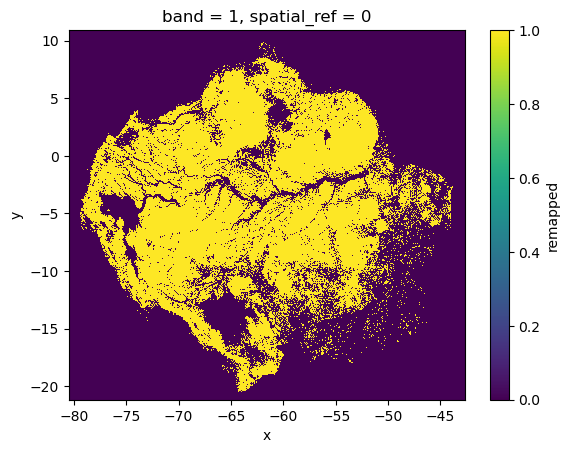

In [10]:
forest.plot()

Clip to Amazonia and add column for forest yes/no

In [27]:
%%time

for m in months[3:4]:#[:-1]:
    print(m)
    
    for sat in ['Terra','Aqua']:
    
        modis = pd.read_csv(f'/projects/shared-buckets/coffield/modis/outputs/amazon/{m.strftime("%Y_%m")}_detections_{sat}.csv')
        modis = gpd.GeoDataFrame(modis, geometry=gpd.GeoSeries.from_xy(modis['longitude'], modis['latitude']), crs=4326)

        #clip to amazonia
        modis = modis.clip(geomc)

        #get corresponding lulc from mapbiomas
        x = modis.longitude.to_xarray()
        y = modis.latitude.to_xarray()
        modis['forest'] = forest.sel(x=x, y=y, method='nearest').data

        #save a version with "forest" 0 or 1 column
        modis.to_csv(f'/projects/my-public-bucket/modis/outputs/amazon/{m.strftime("%Y_%m")}_detections_{sat}.csv', index=False)

2015-12-01 00:00:00
CPU times: user 13.2 s, sys: 189 ms, total: 13.3 s
Wall time: 16.3 s


Mask to forests only and add column for passing spatial-temporal filter yes/no:

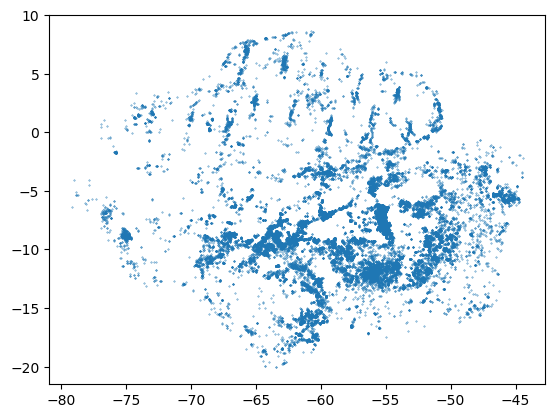

In [28]:
#quick check that things look ok
foo = pd.read_csv('/projects/my-public-bucket/modis/outputs/amazon/2015_09_detections_Terra.csv')
foo = foo[foo.forest==1]

import matplotlib.pyplot as plt
plt.scatter(foo.longitude, foo.latitude, s=0.1)

In [29]:
%%time
#a couple minutes per month to do spatial/temporal filtering

for m in months[:4]: 
    for sat in ['Aqua','Terra']:
        print(m, sat)
        modis = pd.read_csv(f'/projects/shared-buckets/coffield/modis/outputs/amazon/{m.strftime("%Y_%m")}_detections_{sat}.csv')
        
        #filter in space & time: within 4km (0.04 deg) and 4 days of a known fire detection
        
        #need adjacent months included:
        prev_month = m - pd.DateOffset(months=1)
        prev_month = f'/projects/shared-buckets/coffield/modis/outputs/amazon/{prev_month.strftime("%Y_%m")}_detections_{sat}.csv'
        next_month = m + pd.DateOffset(months=1)
        next_month = f'/projects/shared-buckets/coffield/modis/outputs/amazon/{next_month.strftime("%Y_%m")}_detections_{sat}.csv'
    
        if os.path.exists(prev_month):
            print('getting end of previous month')
            adj_dets = pd.read_csv(prev_month)
            adj_dets.acq_date = pd.to_datetime(adj_dets.acq_date)
            last_day = adj_dets.acq_date.max()
            adj_dets = adj_dets[adj_dets.acq_date >= last_day - dt.timedelta(4)]
            modis = pd.concat([adj_dets, modis])
        
        if os.path.exists(next_month):
            print('getting beginning of following month')
            adj_dets = pd.read_csv(next_month)
            adj_dets.acq_date = pd.to_datetime(adj_dets.acq_date)
            first_day = adj_dets.acq_date.min()
            adj_dets = adj_dets[adj_dets.acq_date <= first_day + dt.timedelta(4)]
            modis = pd.concat([modis, adj_dets])
        
        
        #mask to forest only
        modis = modis[modis.forest==1] 
        
        modis.acq_datetime = pd.to_datetime(modis.acq_datetime)
        
        known = modis[modis.fire_mask>6]
    
        #loop through all candidates for current month of interest (slow)
        for i in modis[(modis.fire_mask<7) & (modis.acq_datetime.dt.month==m.month)].index: 
            lon = modis.loc[i, 'longitude']
            lat = modis.loc[i, 'latitude']
            t = modis.loc[i, 'acq_datetime']
            nearby = ((np.abs(known.longitude-lon)<0.04) & (np.abs(known.latitude-lat)<0.04) & (np.abs(known.acq_datetime-t)<dt.timedelta(4))) .sum()
            modis.loc[i, 'pass_filter'] = nearby>0
            
         
        modis = modis[modis.acq_datetime.dt.month == m.month] #clip back down to this month only
        
        #modis = modis[(modis.pass_filter==True) | (modis.fire_mask>6)] #save only passed pixels
        
        #export
        modis.to_csv(f'/projects/my-public-bucket/modis/outputs/amazon/{m.strftime("%Y_%m")}_detections_{sat}_masked_filter.csv', index=False)

print('done')  
    

2015-09-01 00:00:00 Aqua
getting beginning of following month
2015-09-01 00:00:00 Terra
getting beginning of following month
2015-10-01 00:00:00 Aqua
getting end of previous month
getting beginning of following month
2015-10-01 00:00:00 Terra
getting end of previous month
getting beginning of following month
2015-11-01 00:00:00 Aqua
getting end of previous month
getting beginning of following month
2015-11-01 00:00:00 Terra
getting end of previous month
getting beginning of following month
2015-12-01 00:00:00 Aqua
getting end of previous month
getting beginning of following month
2015-12-01 00:00:00 Terra
getting end of previous month
getting beginning of following month
done
CPU times: user 7min 2s, sys: 1.04 s, total: 7min 3s
Wall time: 7min 12s


<h4>See other notebook "amazon_combined_plots" for plotting with lonboard

<h4>Old stuff - Example plots of land cover:

In [140]:
modis

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,acq_datetime,j,geometry,mapbiomas_lulc
298373,-53.099480,-17.891188,8,N,n,2015/09/17,215,2015-09-17 02:15:00 +00:00,614,POINT (-53.09948 -17.89119),9
160228,-53.457867,-17.932903,5,D,x,2015/09/11,1345,2015-09-11 13:45:00 +00:00,478,POINT (-53.45787 -17.93290),4
489462,-53.837597,-16.268661,8,D,n,2015/09/23,1405,2015-09-23 14:05:00 +00:00,999,POINT (-53.83760 -16.26866),4
489431,-53.830547,-16.260612,9,D,h,2015/09/23,1405,2015-09-23 14:05:00 +00:00,999,POINT (-53.83055 -16.26061),4
447982,-53.827835,-16.259039,5,D,x,2015/09/22,1325,2015-09-22 13:25:00 +00:00,115,POINT (-53.82784 -16.25904),4
...,...,...,...,...,...,...,...,...,...,...,...
105648,-60.364502,8.627713,5,D,x,2015/09/08,1445,2015-09-08 14:45:00 +00:00,921,POINT (-60.36450 8.62771),3
300052,-60.014620,4.867323,5,D,x,2015/09/17,1440,2015-09-17 14:40:00 +00:00,881,POINT (-60.01462 4.86732),3
605682,-60.079037,4.910547,5,D,x,2015/09/28,1420,2015-09-28 14:20:00 +00:00,388,POINT (-60.07904 4.91055),3
299897,-60.107594,6.190261,5,D,x,2015/09/17,1440,2015-09-17 14:40:00 +00:00,843,POINT (-60.10759 6.19026),6


In [141]:
palette = ["#ffffff", #from GEE mapbiomas script
  "#32a65e",
  "#32a65e",
  "#1f8d49",
  "#7dc975",
  "#04381d",
  "#026975",
  "#000000",
  "#000000",
  "#7a6c00",
  "#ad975a",
  "#519799",
  "#d6bc74",
  "#d89f5c",
  "#FFFFB2",
  "#edde8e",
  "#000000",
  "#000000",
  "#f5b3c8",
  "#C27BA0",
  "#db7093",
  "#ffefc3",
  "#db4d4f",
  "#ffa07a",
  "#d4271e",
  "#db4d4f",
  "#0000FF",
  "#000000",
  "#000000",
  "#ffaa5f",
  "#9c0027",
  "#091077",
  "#fc8114",
  "#2532e4",
  "#93dfe6",
  "#9065d0",
  "#d082de",
  "#000000",
  "#000000",
  "#f5b3c8",
  "#c71585",
  "#f54ca9",
  "#cca0d4",
  "#dbd26b",
  "#807a40",
  "#e04cfa",
  "#d68fe2",
  "#9932cc",
  "#e6ccff",
  "#02d659",
  "#ad5100",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#CC66FF",
  "#FF6666",
  "#006400",
  "#8d9e8b",
  "#f5d5d5",
  "#ff69b4"]

In [143]:
modis['color'] = [palette[i] for i in modis.mapbiomas_lulc]
modis

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,acq_datetime,j,geometry,mapbiomas_lulc,color
298373,-53.099480,-17.891188,8,N,n,2015/09/17,215,2015-09-17 02:15:00 +00:00,614,POINT (-53.09948 -17.89119),9,#7a6c00
160228,-53.457867,-17.932903,5,D,x,2015/09/11,1345,2015-09-11 13:45:00 +00:00,478,POINT (-53.45787 -17.93290),4,#7dc975
489462,-53.837597,-16.268661,8,D,n,2015/09/23,1405,2015-09-23 14:05:00 +00:00,999,POINT (-53.83760 -16.26866),4,#7dc975
489431,-53.830547,-16.260612,9,D,h,2015/09/23,1405,2015-09-23 14:05:00 +00:00,999,POINT (-53.83055 -16.26061),4,#7dc975
447982,-53.827835,-16.259039,5,D,x,2015/09/22,1325,2015-09-22 13:25:00 +00:00,115,POINT (-53.82784 -16.25904),4,#7dc975
...,...,...,...,...,...,...,...,...,...,...,...,...
105648,-60.364502,8.627713,5,D,x,2015/09/08,1445,2015-09-08 14:45:00 +00:00,921,POINT (-60.36450 8.62771),3,#1f8d49
300052,-60.014620,4.867323,5,D,x,2015/09/17,1440,2015-09-17 14:40:00 +00:00,881,POINT (-60.01462 4.86732),3,#1f8d49
605682,-60.079037,4.910547,5,D,x,2015/09/28,1420,2015-09-28 14:20:00 +00:00,388,POINT (-60.07904 4.91055),3,#1f8d49
299897,-60.107594,6.190261,5,D,x,2015/09/17,1440,2015-09-17 14:40:00 +00:00,843,POINT (-60.10759 6.19026),6,#026975


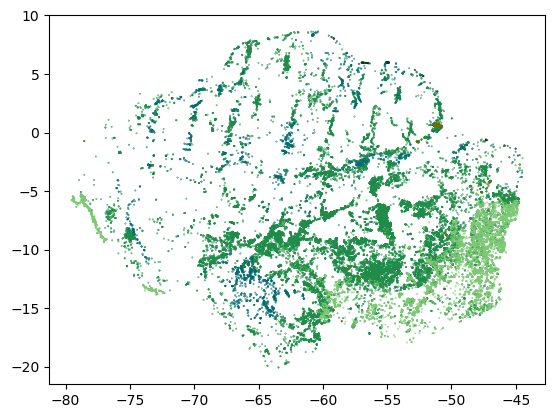

In [144]:
import matplotlib.pyplot as plt
plt.scatter(modis.longitude, modis.latitude, c=modis.color, s=0.1)

Text(0.5, 1.0, 'known detections')

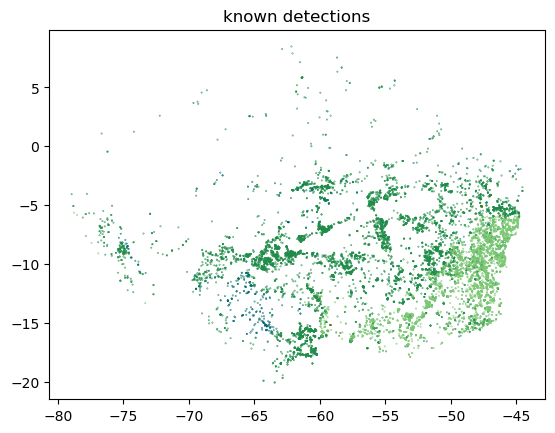

In [148]:
knowns = modis[modis.fire_mask > 6]
plt.scatter(knowns.longitude, knowns.latitude, c=knowns.color, s=0.1)
plt.title('known detections')

Text(0.5, 1.0, 'candidate detections')

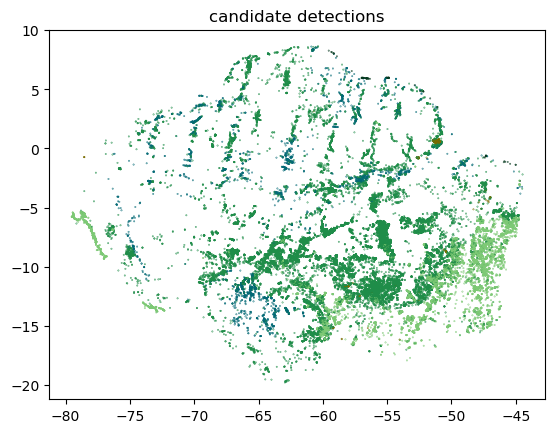

In [149]:
cands = modis[modis.fire_mask < 7]
plt.scatter(cands.longitude, cands.latitude, c=cands.color, s=0.1)
plt.title('candidate detections')

Text(0.5, 1.0, 'known vs candidates')

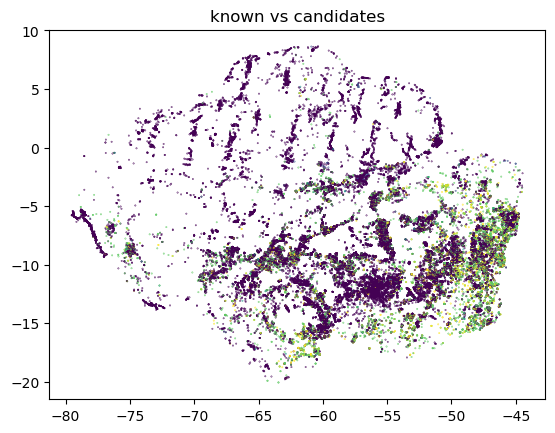

In [150]:
plt.scatter(modis.longitude, modis.latitude, c=modis.fire_mask, s=0.1)
plt.title('known vs candidates')

In [158]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gs

#define colormap for fire mask
newcolors = [mpl.colormaps['tab10'](c) for c in [4,6,5,0,9,2,7,8,1,3]]
#newcolors = [mpl.colormaps['tab10'](c) for c in [9,9,9,9,9,9,9,3,3,3]] #just old vs new dets
newcmp = ListedColormap(newcolors)

/projects/myenvs/candidates-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


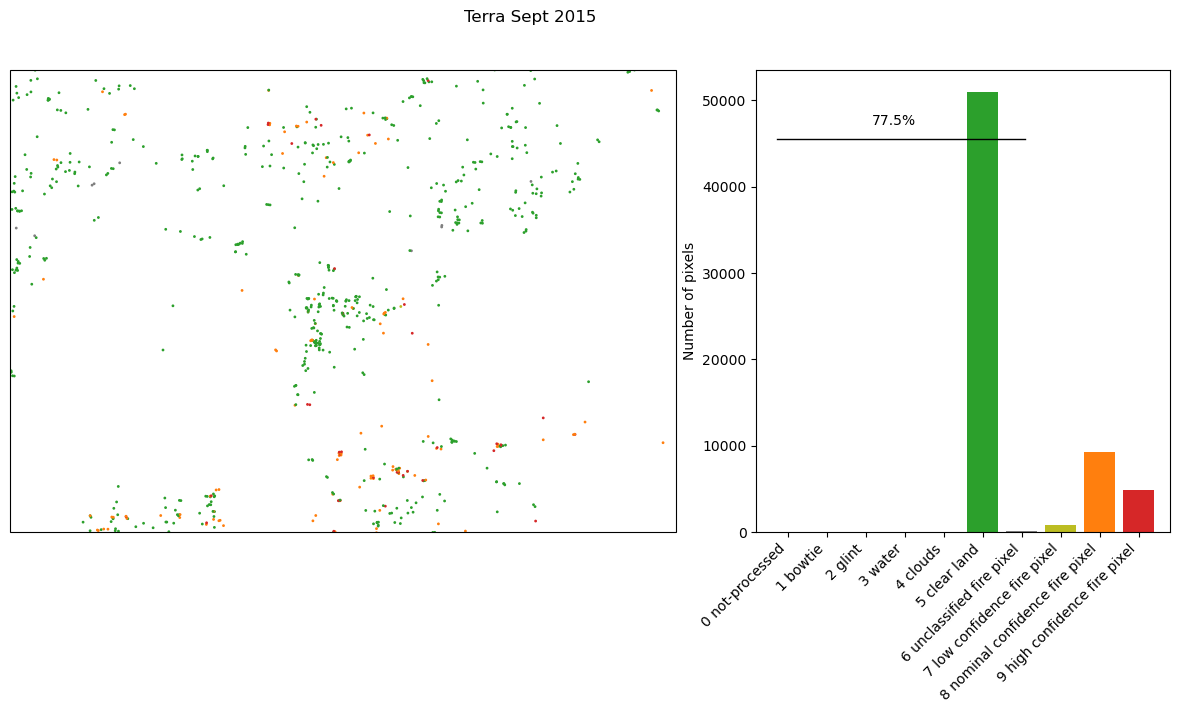

In [160]:
#plot
#extent = [-54.8,-54.44,-3.43,-2.96] #santarem zoom
EXTENT = [-56.6,-4.0,-52.7,-1.3] #santarem

#map (left) + bars (right) ---------------------------------------
fig = plt.figure(figsize=(16,6))
grid = gs.GridSpec(1,2, width_ratios=[2,1])
ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax2 = plt.subplot(grid[1])

ax.set_extent([EXTENT[0],EXTENT[2],EXTENT[1],EXTENT[3]])

ax.scatter(modis.longitude, modis.latitude, c=newcmp(modis.fire_mask.astype(int)), s=1, transform=ccrs.Geodetic(), cmap=newcmp)

#right panel barchart
values, counts = np.unique(modis['fire_mask'], return_counts=True)
fraction_missing = counts[values<7].sum() / counts.sum()
colors = [newcmp(c) for c in values]
ax2.bar(values, counts, color=colors)
labels = ['0 not-processed', '1 bowtie', '2 glint', '3 water','4 clouds',
          '5 clear land','6 unclassified fire pixel','7 low confidence fire pixel',
          '8 nominal confidence fire pixel','9 high confidence fire pixel']
ax2.set_xlim((-0.8,9.8))
ax2.set_xticks(range(10))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Number of pixels')    
ax2.annotate('{:.1f}%'.format(fraction_missing*100), xy=(0.28, 0.88),  size=10, xycoords=ax2.transAxes)
ax2.plot((0.05,0.65), (0.85, 0.85), transform=ax2.transAxes, c='k', linewidth=1)
plt.suptitle('Terra Sept 2015') 

plt.subplots_adjust(wspace=0)

/projects/myenvs/candidates-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


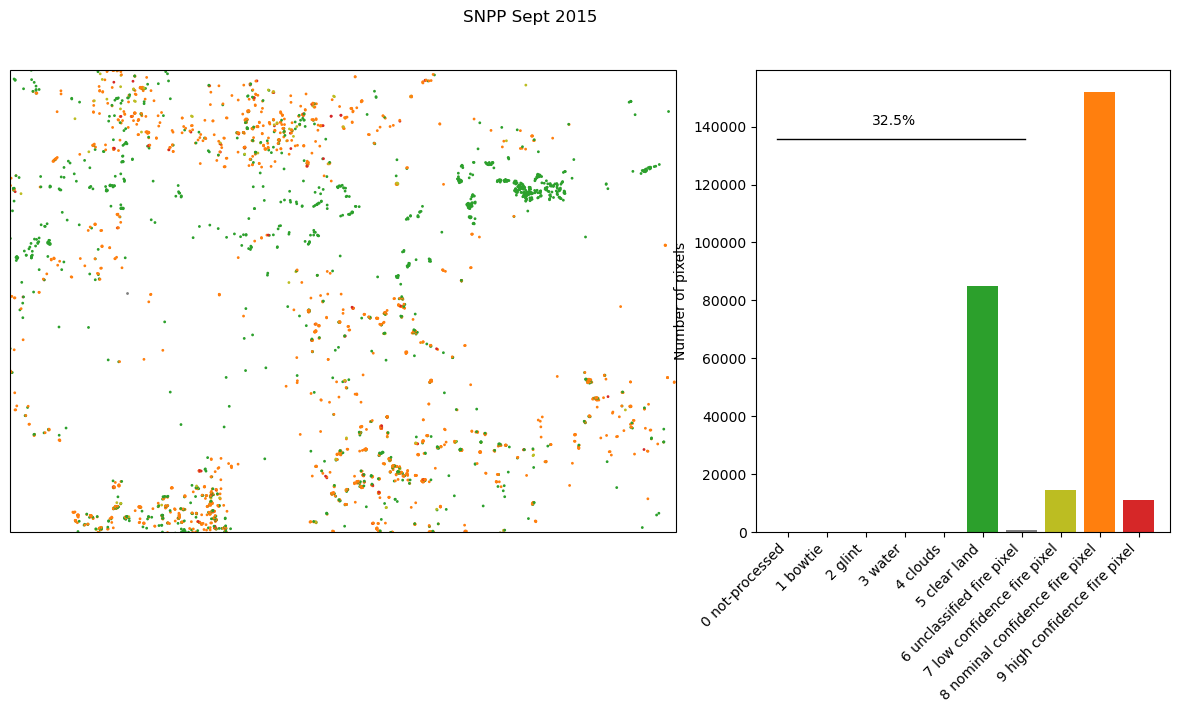

In [176]:
#plot viirs
viirs = pd.read_csv('/projects/my-public-bucket/viirs/outputs/amazon/2015_09_detections_SNPP_masked.csv')

EXTENT = [-56.6,-4.0,-52.7,-1.3] #santarem

#map (left) + bars (right) ---------------------------------------
fig = plt.figure(figsize=(16,6))
grid = gs.GridSpec(1,2, width_ratios=[2,1])
ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax2 = plt.subplot(grid[1])

ax.set_extent([EXTENT[0],EXTENT[2],EXTENT[1],EXTENT[3]])

ax.scatter(viirs.longitude, viirs.latitude, c=newcmp(viirs.fire_mask.astype(int)), s=1, transform=ccrs.Geodetic(), cmap=newcmp)

#right panel barchart
values, counts = np.unique(viirs['fire_mask'], return_counts=True)
fraction_missing = counts[values<7].sum() / counts.sum()
colors = [newcmp(int(c)) for c in values]
ax2.bar(values, counts, color=colors)
labels = ['0 not-processed', '1 bowtie', '2 glint', '3 water','4 clouds',
          '5 clear land','6 unclassified fire pixel','7 low confidence fire pixel',
          '8 nominal confidence fire pixel','9 high confidence fire pixel']
ax2.set_xlim((-0.8,9.8))
ax2.set_xticks(range(10))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Number of pixels')    
ax2.annotate('{:.1f}%'.format(fraction_missing*100), xy=(0.28, 0.88),  size=10, xycoords=ax2.transAxes)
ax2.plot((0.05,0.65), (0.85, 0.85), transform=ax2.transAxes, c='k', linewidth=1)
plt.suptitle('SNPP Sept 2015') 

plt.subplots_adjust(wspace=0)